In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [4]:
train_x = pd.read_csv('train_features_2013-03-07.csv')
train_y = pd.read_csv('train_salaries_2013-03-07.csv')

In [5]:
train_x.columns.values

array(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'], dtype=object)

### Data Validation
 - The data appears to be clean from the plots below. 
 - No missing values are observed as the list at the end shows. 
 - The boxplots do not show outliers for continuous features except salary. 
 - The response variable 'salary' has a few zero values. These will be removed to avoid outliers.
 - The count plots show uniformly distributed categories for each categorical feature except 'major' in which half the jobs correspond to no major and the other half are somewhat uniformly distributed across majors.

In [6]:
train = pd.merge(train_x,train_y,on='jobId')

In [7]:
def summarize(feature, df):
        return sns.countplot(y=feature,data=df) if type(df[feature][0]) == str else sns.boxplot(x=feature,data=df, orient='h')

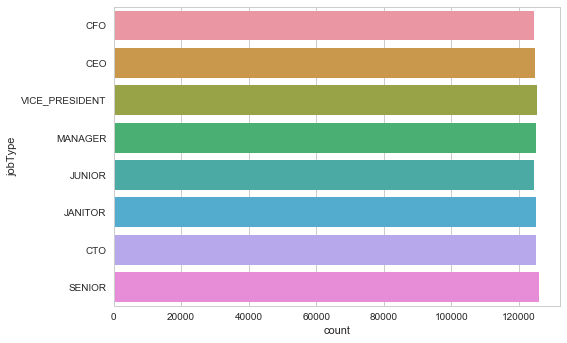

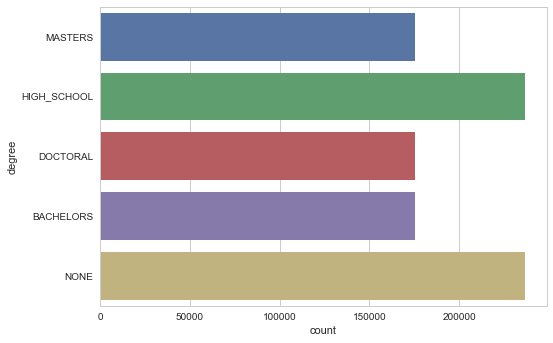

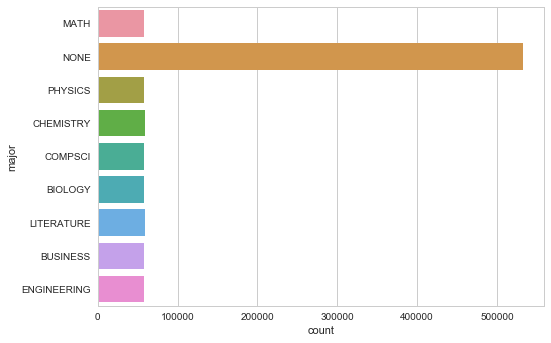

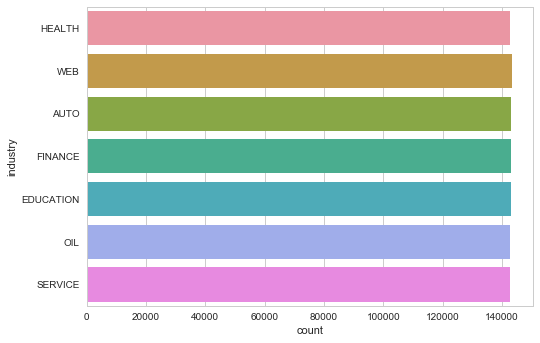

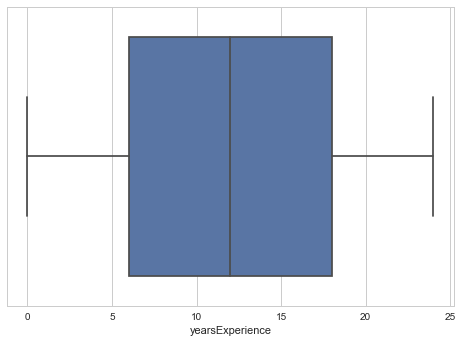

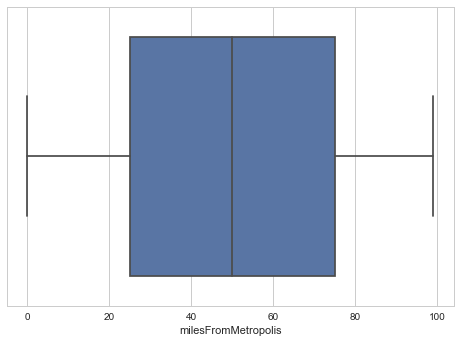

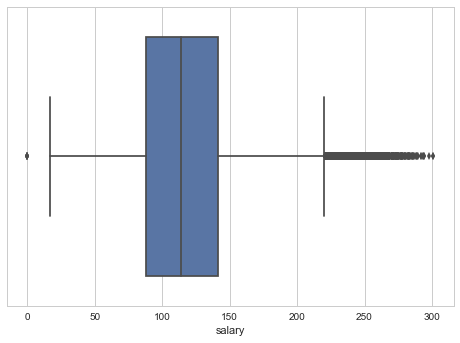

In [8]:
for i,col in enumerate(list(train.columns.values)[2:]):
    plt.figure(i)
    summarize(col,train)

In [9]:
[(i,len(train[train[i].isnull()==True])) for i in train.columns.values]

[('jobId', 0),
 ('companyId', 0),
 ('jobType', 0),
 ('degree', 0),
 ('major', 0),
 ('industry', 0),
 ('yearsExperience', 0),
 ('milesFromMetropolis', 0),
 ('salary', 0)]

### Plotting Features against Response
 - In this section we plot every feature against the response variable (salary) to visualize any relationships that may exist.
 - Categorical features are visualized using violin plots which display not only the median and quartiles but also where the bulk of the distribution lies.
 - Conitnuous features are visualized using a scatterplot with a best-fit regression line drawn through them.

In [10]:
def summarize1(feature, df):
    if type(df[feature][0]) == str:
            return sns.violinplot(y=feature, x="salary", data=df, split=True)
    else:
            return sns.lmplot(x=feature,y="salary",data=df)

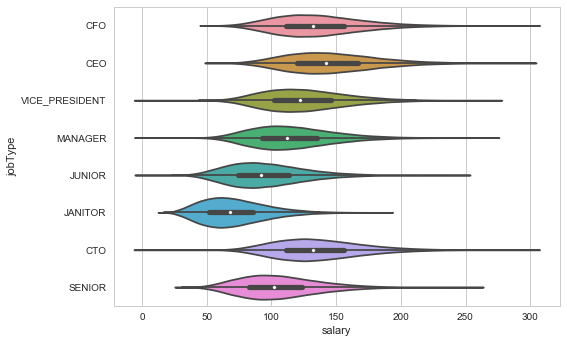

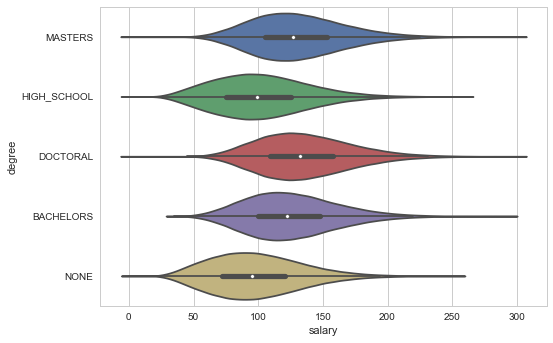

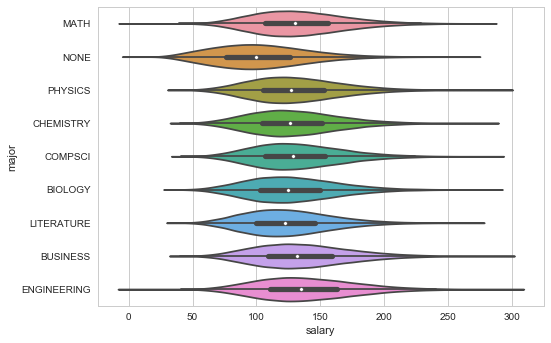

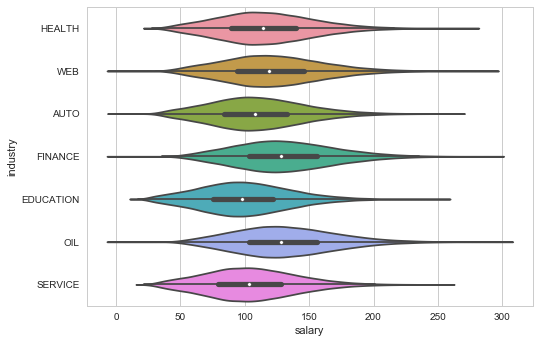

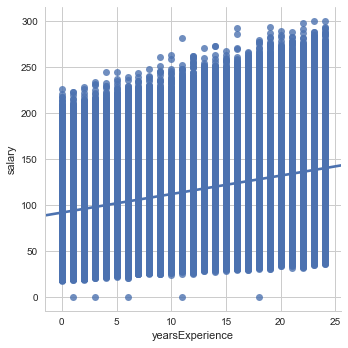

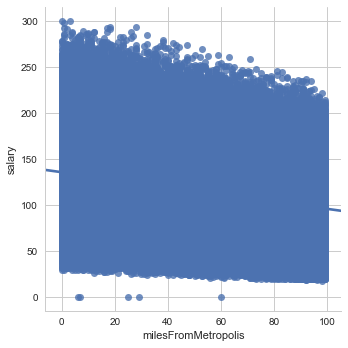

In [11]:
for i,col in enumerate(list(train.columns.values)[2:-1]):
    plt.figure(i)
    summarize1(col,train)

### Feature Engineering
 - Degree and Job Type are identified as ordinal categorical features in that they can be ordered from lowest to highest.
 - Major and Industry are identified as nominal categorical features. These features do not follow an order.
 - Ordinal categorical features are coded to reflect their underlying order.
 - Nominal categorical features are turned into one-hot encoded dummy variables.

In [12]:
test_x = pd.read_csv('test_features_2013-03-07.csv')

In [ ]:
print test_x.jobType.unique()
print test_x.degree.unique()
print test_x.major.unique()
print test_x.industry.unique()
print test_x.milesFromMetropolis.describe()
print test_x.yearsExperience.describe()

Train and test sets are combined so as to create the same variables for both

In [13]:
train_x['isTrain'] = 1
test_x['isTrain'] = 0
big_df = pd.concat([train_x,test_x],axis=0)

In [14]:
big_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,isTrain
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,1
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,1
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,1
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,1
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,1


In [15]:
ord_features = ['jobType','degree']
big_df['jobType'] = big_df['jobType'].astype('category')
big_df['jobType'] = big_df['jobType'].cat.reorder_categories(['JANITOR','JUNIOR','SENIOR','MANAGER','VICE_PRESIDENT','CTO','CFO','CEO'], ordered=True)
big_df['jobType'] = big_df['jobType'].cat.codes

In [16]:
big_df['degree'] = big_df['degree'].astype('category')
big_df['degree'] = big_df['degree'].cat.reorder_categories(['NONE','HIGH_SCHOOL','BACHELORS','MASTERS','DOCTORAL'], ordered=True)
big_df['degree'] = big_df['degree'].cat.codes

In [17]:
cat_features = ['major','industry']
big_df = pd.get_dummies(big_df, columns=['major','industry'], prefix=['major','ind'])

In [18]:
big_df.columns.values

array(['jobId', 'companyId', 'jobType', 'degree', 'yearsExperience',
       'milesFromMetropolis', 'isTrain', 'major_BIOLOGY', 'major_BUSINESS',
       'major_CHEMISTRY', 'major_COMPSCI', 'major_ENGINEERING',
       'major_LITERATURE', 'major_MATH', 'major_NONE', 'major_PHYSICS',
       'ind_AUTO', 'ind_EDUCATION', 'ind_FINANCE', 'ind_HEALTH', 'ind_OIL',
       'ind_SERVICE', 'ind_WEB'], dtype=object)

Train and test sets are separated once the variables are created

In [19]:
train_x = big_df[big_df['isTrain'] == 1].drop('isTrain',axis=1)
test_x = big_df[big_df['isTrain'] == 0].drop('isTrain',axis=1)

In [20]:
train_x = train_x[~train_x['jobId'].isin(list(train_y['jobId'][train_y['salary']==0]))]
train_y = train_y[train_y['salary']!=0]

In [21]:
x = train_x[[col for col in train_x.columns if col not in ['jobId','companyId']]]
y = train_y[['salary']]

##### The train set is split into training and validation sets in order to select the best model.

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

### Linear Regression
The first algorithm we try out is linear regression because it is the most intertpretable and straightforard algorithm. Moreover, in situations where the relationship is linear, linear regression performs the best.

In [24]:
algo = linear_model.LinearRegression()
algo.fit(x_train, y_train)
y_pred = algo.predict(x_test)
print "MSE: ", mean_squared_error(y_pred, y_test)
print
print "Coefficients:"
coefficients = pd.concat([pd.DataFrame(x_train.columns),pd.DataFrame(np.transpose(algo.coef_))], axis = 1)
coefficients.columns = [['Feature','Coefficient']]
print
coefficients

 MSE:  394.458575188

Coefficients:



,Feature,Coefficient
0,jobType,8.720954
1,degree,5.039655
2,yearsExperience,2.008906
3,milesFromMetropolis,-0.399161
4,major_BIOLOGY,-2.407858
5,major_BUSINESS,5.377441
6,major_CHEMISTRY,-1.255812
7,major_COMPSCI,1.659241
8,major_ENGINEERING,8.252099
9,major_LITERATURE,-5.927242


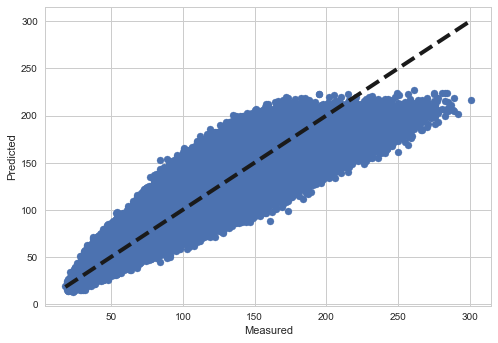

In [25]:
fig, ax = plt.subplots()
ax.scatter(y_test[['salary']], y_pred)
ax.plot([y_test[['salary']].min(), y_test[['salary']].max()], [y_test[['salary']].min(), y_test[['salary']].max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Lasso
I implemented lasso to see if regularization to prevent overfitting helped improve the validation set accuracy. Lasso attaches a penalty to the number of variables and pushes the less important variables to zero. While it made clear which variables were important, it did not produce better results.

In [26]:
algo = linear_model.Lasso()
algo.fit(x_train, y_train)
y_pred = algo.predict(x_test)
print "MSE: ", mean_squared_error(y_test, y_pred)
print
print "Coefficients:"
coefficients = pd.concat([pd.DataFrame(x_train.columns),pd.DataFrame(np.transpose(algo.coef_))], axis = 1)
coefficients.columns = [['Feature','Coefficient']]
print
coefficients

MSE:  447.824600114

Coefficients:



,Feature,Coefficient
0,jobType,8.670186
1,degree,6.603708
2,yearsExperience,1.990647
3,milesFromMetropolis,-0.398173
4,major_BIOLOGY,-0.000000
5,major_BUSINESS,0.000000
6,major_CHEMISTRY,-0.000000
7,major_COMPSCI,0.000000
8,major_ENGINEERING,0.000000
9,major_LITERATURE,-0.000000


### Random Forest
Next we try out random forest because they are great at modeling non-linear relationships and do not lose a lot of interpretability since they provide feature importance. They also control for overfitting through parameter tuning. However, at each split it only considers a random subset of variable unless the parameter specifically tells it to consider all.

In [27]:
algo = RandomForestRegressor(n_estimators=20)
algo.fit(x_train, y_train)
y_pred = algo.predict(x_test)
print "MSE: %4.3f" %mean_squared_error(y_test, y_pred)
print
print "Fetaure Importances:"
coefficients = pd.concat([pd.DataFrame(x_train.columns),pd.DataFrame(np.transpose(algo.feature_importances_))], axis = 1)
coefficients.columns = [['Feature','Importance']]
print
coefficients

/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


MSE: 451.018

Fetaure Importances:



,Feature,Importance
0,jobType,0.336717
1,degree,0.120623
2,yearsExperience,0.191546
3,milesFromMetropolis,0.200439
4,major_BIOLOGY,0.005024
5,major_BUSINESS,0.006554
6,major_CHEMISTRY,0.005118
7,major_COMPSCI,0.005079
8,major_ENGINEERING,0.007571
9,major_LITERATURE,0.005036


### Gradient Boosting
Gradient Boosting is known for its robustness and results. It uses a bunch of weak learners to improve on its prediction power iteratively. It is good for modeling non-linearity and provided opportunities for parameter tuning to avoid overfitting. It does not lose interpretability either since it ranks features based on how much of an improvement they resulted in.

Since there are multiple parameters to be tuned, I used Grid Search to settle on the best parameters.

In [12]:
from sklearn import grid_search
from sklearn.ensemble import GradientBoostingRegressor
gb_grid_params = {'learning_rate': [0.2, 0.1, 0.05],
              'max_depth': [7, 8, 9]
              }
print(gb_grid_params)

gb_gs = GradientBoostingRegressor(n_estimators = 50)

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=2,
                               scoring='mean_squared_error',
                               verbose = 3, 
                               n_jobs=10)
clf.fit(x_train, y_train)

/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'learning_rate': [0.2, 0.1, 0.05], 'max_depth': [7, 8, 9]}
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] learning_rate=0.2, max_depth=7 ..................................
[CV] learning_rate=0.2, max_depth=7 ..................................
[CV] learning_rate=0.2, max_depth=8 ..................................
[CV] learning_rate=0.2, max_depth=8 ..................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] learning_rate=0.2, max_depth=9 ..................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] learning_rate=0.2, max_depth=9 ..................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] learning_rate=0.1, max_depth=7 ..................................
[CV] learning_rate=0.1, max_depth=7 ..................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] learning_rate=0.1, max_depth=8 ..................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] learning_rate=0.1, max_depth=8 ..................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array w

[CV] ...... learning_rate=0.2, max_depth=7, score=-360.851419 -22.8min
[CV] learning_rate=0.1, max_depth=9 ..................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.2, max_depth=7, score=-360.146581 -22.8min
[CV] learning_rate=0.1, max_depth=9 ..................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.1, max_depth=7, score=-363.915885 -24.3min
[CV] learning_rate=0.05, max_depth=7 .................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.1, max_depth=7, score=-362.529498 -24.4min
[CV] learning_rate=0.05, max_depth=7 .................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.2, max_depth=8, score=-361.498360 -32.4min
[CV] learning_rate=0.05, max_depth=8 .................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.2, max_depth=8, score=-361.484461 -32.9min
[CV] learning_rate=0.05, max_depth=8 .................................


[Parallel(n_jobs=10)]: Done   6 out of  18 | elapsed: 32.9min remaining: 65.9min
/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.1, max_depth=8, score=-361.934413 -35.6min
[CV] learning_rate=0.05, max_depth=9 .................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.1, max_depth=8, score=-361.304927 -35.7min
[CV] learning_rate=0.05, max_depth=9 .................................


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ..... learning_rate=0.05, max_depth=7, score=-398.749885 -17.8min


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ..... learning_rate=0.05, max_depth=7, score=-396.938846 -17.8min


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.2, max_depth=9, score=-364.123115 -46.1min


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.2, max_depth=9, score=-363.446744 -46.5min


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ..... learning_rate=0.05, max_depth=8, score=-387.917968 -20.9min


[Parallel(n_jobs=10)]: Done  13 out of  18 | elapsed: 53.3min remaining: 20.5min
/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ..... learning_rate=0.05, max_depth=8, score=-386.398412 -20.5min


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.1, max_depth=9, score=-361.938906 -33.0min


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ...... learning_rate=0.1, max_depth=9, score=-361.130425 -33.0min


/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ..... learning_rate=0.05, max_depth=9, score=-380.753946 -22.8min
[CV] ..... learning_rate=0.05, max_depth=9, score=-379.213545 -22.7min


[Parallel(n_jobs=10)]: Done  18 out of  18 | elapsed: 58.5min finished
/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=2, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=10,
       param_grid={'learning_rate': [0.2, 0.1, 0.05], 'max_depth': [7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=3)

In [13]:
print clf.best_params_, clf.best_score_

{'learning_rate': 0.2, 'max_depth': 7} -360.49899987


In [28]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=30, max_depth=7, learning_rate=0.2)
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test.as_matrix())
print mean_squared_error(y_test, y_pred)

/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


362.350929439


In [29]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=40, max_depth=7, learning_rate=0.2)
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test.as_matrix())
print mean_squared_error(y_test, y_pred)

360.528535134


In [30]:
gb = GradientBoostingRegressor(n_estimators=50, max_depth=7, learning_rate=0.2)
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test.as_matrix())
print mean_squared_error(y_test, y_pred)

359.599845187


In [31]:
gb = GradientBoostingRegressor(n_estimators=70, max_depth=7, learning_rate=0.2)
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test.as_matrix())
print mean_squared_error(y_test, y_pred)

358.949905892


### RuleFit
RuleFit combines the power of ensemble and linear regression to produce optimized and interpretable results. It starts by producing rules through the use of trees and it ends by fitting those rules using linear regression. The result is a set of variable coefficients and rules that are easily understandable. Ideally, RuleFit would be the best algorithm to use since it combines the power of linear regression and trees. With optimized gradient boosting parameters, RuleFit failed to work (the current library does not support high functionality). However, to demonstrate its capabilities, I ran RuleFit with a smaller number of estimators and depth to give an idea of how it works.

In [32]:
from rulefit import RuleFit
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=20, max_depth=3, learning_rate=0.1)
rf = RuleFit(gb)
x_train1 = x_train.as_matrix()
rf.fit(x_train1, y_train, feature_names=x_train.columns.values)
rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values(by = "support", ascending = 0)
y_pred = rf.predict(x_test.as_matrix())
print 'MSE: ', round(mean_squared_error(y_pred, y_test),2)
rules

/Users/zainabdanish/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE:  400.17


,rule,type,coef,support
0,jobType,linear,7.583793,1.000000
1,degree,linear,4.746397,1.000000
2,yearsExperience,linear,1.898374,1.000000
3,milesFromMetropolis,linear,-0.372088,1.000000
8,major_ENGINEERING,linear,2.511658,1.000000
9,major_LITERATURE,linear,-0.337376,1.000000
11,major_NONE,linear,-1.960797,1.000000
13,ind_AUTO,linear,-3.831133,1.000000
14,ind_EDUCATION,linear,-6.228818,1.000000
15,ind_FINANCE,linear,9.634721,1.000000


### Final Model
Although other algorithms are quite powerful, gradient boosting proved to be the best in our situation. Overfitting was prevented by keeping the number of trees and the learning rate small.

In [52]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=40, max_depth=7, learning_rate=0.2)
gb.fit(x, y)
test_features = test_x[[col for col in test_x.columns if col not in ['jobId','companyId']]]
pred_y = gb.predict(test_features)
test_y = pd.concat([test_x['jobId'],pd.DataFrame({'salary': np.round(pred_y,0).astype(int)})], axis = 1)

In [51]:
test_y.head()

,jobId,salary
0,JOB1362685407687,112
1,JOB1362685407688,93
2,JOB1362685407689,179
3,JOB1362685407690,103
4,JOB1362685407691,116


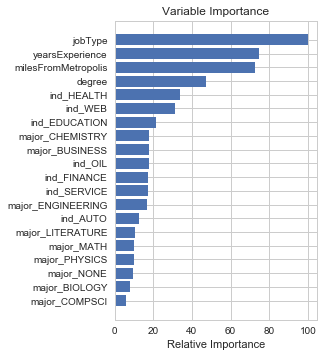

In [53]:
feature_importance = gb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x.columns.values[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [54]:
test_y.to_csv('test_salaries.csv', index=False)